In [1]:
import numpy as np
import xarray as xr
import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from data.transform import Normalize

def print_ms(x):
    """Print mean and std."""
    if not isinstance(x, dict):
        x = {'x': x}
    for key, val in x.items():
        print(f'{key}: mean={val.mean()}, std={val.std()}')

In [2]:
# Craete dummy xarray data.

seq_len = 500
num_sites = 3
ds = xr.Dataset()
for x in range(3):
    # Random data with different mean (=x)
    ds[f'x{x}'] = xr.DataArray(np.random.normal(loc=x, scale=10., size=(seq_len, num_sites)).astype('float32'), dims=['time', 'site'], coords={'time': range(seq_len), 'site': [f'S{s}' for s in range(num_sites)]})

print(ds)

<xarray.Dataset>
Dimensions:  (site: 3, time: 500)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * site     (site) <U2 'S0' 'S1' 'S2'
Data variables:
    x0       (time, site) float32 -16.22 -6.244 1.891 ... 7.109 -3.053 8.895
    x1       (time, site) float32 1.185 -7.624 -5.375 ... -15.43 -16.2 1.81
    x2       (time, site) float32 -17.07 -1.175 -12.18 ... 0.8758 3.789 5.551


In [3]:
# Split into training and test set.

train_ds = ds.sel(site='S0').isel(time=range(250))
valid_ds = ds.sel(site='S0').isel(time=range(250, 500))

In [4]:
# Create a normalizer using training data.

norm = Normalize()
norm.register_dict({
    'x0': train_ds.x0.values,
    'x1': train_ds.x1.values,
    'x2': train_ds.x2.values,
})
print(norm)

Normalize(dtype=float32)
----------------------------------------
 * x0: 0.088 (9.569 std)
 * x1: 1.756 (11.146 std)
 * x2: 1.865 (9.238 std)



In [5]:
# Register manually (pass mean and std instead of data), e.g. for latent variables.

norm.register_manually('my_latent_var', mean=10., std=2.)
print(norm)

Normalize(dtype=float32)
----------------------------------------
 * x0: 0.088 (9.569 std)
 * x1: 1.756 (11.146 std)
 * x2: 1.865 (9.238 std)
 * my_latent_var: 10.000 (2.000 std)



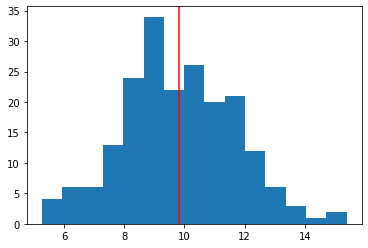

In [6]:
# We can now scale a latent variable ~N(0, 1) to the expected range. As we set mean=10., std=2.,
# the result should be this should be ~N(10, 2).

x = np.random.normal(loc=0, scale=1, size=200)
scaled = norm.unnormalize('my_latent_var', x)
plt.hist(scaled, bins=15);
plt.axvline(scaled.mean(), color='red')

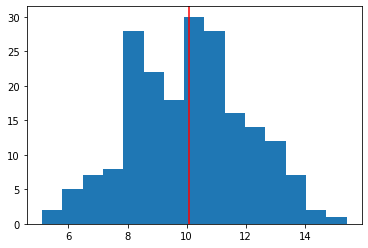

In [7]:
# The same works with torch.Tensors:

x = torch.randn(200)
scaled = norm.unnormalize('my_latent_var', x)
plt.hist(scaled.numpy(), bins=15);
plt.axvline(scaled.mean(), color='red')

In [8]:
# Build a simple pytorch dataset.

class SiteData(Dataset):
    def __init__(self, ds, dtype=np.float32):
        super().__init__()
        
        self.ds = ds
        self.dtype = dtype

    def __len__(self):
        return len(self.ds.time)

    def __getitem__(self, ind):
        d = self.ds.isel(time=ind)
        return {
            'x0': d['x0'].values.astype(self.dtype),
            'x1': d['x1'].values.astype(self.dtype),
            'x2': d['x2'].values.astype(self.dtype),
        }

data = SiteData(train_ds)

In [9]:
# Load one sample.

d = data[0]
print(d)

{'x0': array(-16.221687, dtype=float32), 'x1': array(1.1853368, dtype=float32), 'x2': array(-17.06528, dtype=float32)}


In [10]:
# Normalize sample.

d_norm = norm.normalize_dict(d, return_stack=True)
print(d_norm)

[-1.7045407  -0.05119514 -2.049146  ]


In [11]:
# Buid a pytorch dataloader.

dl = DataLoader(data, batch_size=16)

# Get first batch.

batch = next(iter(dl))

# Access data;

x0 = batch['x0']
x1 = batch['x1']
x2 = batch['x2']

In [12]:
# Validity check.

torch.isclose(x2, norm.unnormalize('x2', norm.normalize('x2', x2)))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [13]:
# Normalize single variable.

print_ms(norm.normalize('x2', x2))

x: mean=-0.2951081395149231, std=1.0952601432800293


In [14]:
# Normalize entire batch.

print_ms(norm.normalize_dict(batch))

x0: mean=0.04550619795918465, std=1.303162693977356
x1: mean=0.038170237094163895, std=1.0801035165786743
x2: mean=-0.2951081395149231, std=1.0952601432800293


In [15]:
# Normalize a subset of variables in batch.

norm.normalize_dict(batch, variables=['x0', 'x1'])

{'x0': tensor([-1.7045,  1.1865, -2.2911,  0.0440, -0.0979, -0.1837, -0.3134,  0.0789,
          0.5382,  0.1180,  1.6209, -1.4101,  3.0113, -0.9519,  0.1448,  0.9383]),
 'x1': tensor([-0.0512, -1.2015,  0.4290, -0.0860,  0.3286, -1.2472,  2.7014,  0.4281,
          0.0311, -1.1565,  0.3617, -1.8270,  1.2356, -0.1792,  0.3254,  0.5184])}

In [16]:
# Normalize a subset of variables in batch and stack along last dimension.

x = norm.normalize_dict(batch, variables=['x0', 'x1'], return_stack=True)

# The first dimension is the batch size, the second the two variables that we selected, x0 and x1.

x.shape

torch.Size([16, 2])